## 분석하면서 생각한 핵심포인트
  - train[family_size] > 7 인 이상치 제거
  - 중복 데이터 처리를 위해 개인정보를 모두 합쳐 ID 변수 생성
  (단, 같은 사용자가 여러번 카드를 발급할 수 있다는 가정 하에 begin_month는 개인정보에서 제외함)
  - 개인의 특성이 될 만한 파생변수 추가 
  - Catboost 모델 사용

### Google Colab mount

In [5]:
#from google.colab import drive
#drive.mount('/content/drive')

### 패키지 설치

In [1]:
#!pip install catboost
#!pip install category_encoders

     ---------------------------------------- 72.4/72.4 kB 3.9 MB/s eta 0:00:00
     ------------------------------------- 233.8/233.8 kB 14.0 MB/s eta 0:00:00
     ---------------------------------------- 9.1/9.1 MB 29.1 MB/s eta 0:00:00


## 라이브러리 구성

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings, random
warnings.filterwarnings(action='ignore')

from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from category_encoders.ordinal import OrdinalEncoder
from sklearn.model_selection import StratifiedKFold

from sklearn.cluster import KMeans
from catboost import CatBoostClassifier, Pool


## 데이터 불러오기

In [19]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
test.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month
0,26457,M,Y,N,0,112500.0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,-21990,365243,1,0,1,0,NaN,2.0,-60.0
1,26458,F,N,Y,0,135000.0,State servant,Higher education,Married,House / apartment,-18964,-8671,1,0,1,0,Core staff,2.0,-36.0
2,26459,F,N,Y,0,69372.0,Working,Secondary / secondary special,Married,House / apartment,-15887,-217,1,1,1,0,Laborers,2.0,-40.0
3,26460,M,Y,N,0,112500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-19270,-2531,1,1,0,0,Drivers,2.0,-41.0
4,26461,F,Y,Y,0,225000.0,State servant,Higher education,Married,House / apartment,-17822,-9385,1,1,0,0,Managers,2.0,-8.0


## 데이터 전처리

### 1. 결측치 처리

In [20]:
train.fillna('NaN', inplace=True) 
test.fillna('NaN', inplace=True)

### 2. 이상치 처리
-  train['family_size'] > 7 인 데이터 제거

In [21]:
train = train[(train['family_size'] <= 7)]
train = train.reset_index(drop=True)

## Feature Engineering

### 1. 의미없는 변수 제거
- index 제거
- FLAG_MOBIL 삭제:모든 값이 1로 동일 

In [22]:
train.drop(['index', 'FLAG_MOBIL'], axis=1, inplace=True)
test.drop(['index', 'FLAG_MOBIL'], axis=1, inplace=True)

### 2. DAYS_EMPLOYED 
- 양수인 데이터는 현재 무직자로 판단, 0 처리

In [23]:
train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'].map(lambda x: 0 if x > 0 else x)
test['DAYS_EMPLOYED'] = test['DAYS_EMPLOYED'].map(lambda x: 0 if x > 0 else x)

### 3. DAYS_BIRTH, begin_month, DAYS_EMPLOYED
-  음수값 -> 양수 변환

In [24]:
feats = ['DAYS_BIRTH', 'begin_month', 'DAYS_EMPLOYED']
for feat in feats:
    train[feat]=np.abs(train[feat])
    test[feat]=np.abs(test[feat])

In [25]:
train

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,13899,4709,0,0,0,NaN,2.0,6.0,1.0
1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,11380,1540,0,0,1,Laborers,3.0,5.0,1.0
2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,19087,4434,0,1,0,Managers,2.0,22.0,2.0
3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,15088,2092,0,1,0,Sales staff,2.0,37.0,0.0
4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,15037,2105,0,0,0,Managers,2.0,26.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26446,F,N,N,2,225000.0,State servant,Secondary / secondary special,Married,House / apartment,12079,1984,0,0,0,Core staff,4.0,2.0,1.0
26447,F,N,Y,1,180000.0,Working,Higher education,Separated,House / apartment,15291,2475,0,0,0,NaN,2.0,47.0,2.0
26448,F,Y,N,0,292500.0,Working,Secondary / secondary special,Civil marriage,With parents,10082,2015,0,0,0,Core staff,2.0,25.0,2.0
26449,M,N,Y,0,171000.0,Working,Incomplete higher,Single / not married,House / apartment,10145,107,0,0,0,Laborers,1.0,59.0,2.0


### 4. 파생변수
 - numeric 변수는 최대한 다양한 특징을 보일 수 있도록 생성
 - category 변수는 여러가지를 조합해 보았지만 전체 변수를 합친 ID 하나만 만들었을때 가장 logloss가 낮았음
 - ref) rollcake님 글 https://dacon.io/competitions/official/235713/codeshare/2526?page=1&dtype=recent

In [26]:
for df in [train,test]:
    # before_EMPLOYED: 고용되기 전까지의 일수
    df['before_EMPLOYED'] = df['DAYS_BIRTH'] - df['DAYS_EMPLOYED']
    df['income_total_befofeEMP_ratio'] = df['income_total'] / df['before_EMPLOYED']
    df['before_EMPLOYED_m'] = np.floor(df['before_EMPLOYED'] / 30) - ((np.floor(df['before_EMPLOYED'] / 30) / 12).astype(int) * 12)
    df['before_EMPLOYED_w'] = np.floor(df['before_EMPLOYED'] / 7) - ((np.floor(df['before_EMPLOYED'] / 7) / 4).astype(int) * 4)
    
    #DAYS_BIRTH 파생변수- Age(나이), 태어난 월, 태어난 주(출생연도의 n주차)
    df['Age'] = df['DAYS_BIRTH'] // 365
    df['DAYS_BIRTH_m'] = np.floor(df['DAYS_BIRTH'] / 30) - ((np.floor(df['DAYS_BIRTH'] / 30) / 12).astype(int) * 12)
    df['DAYS_BIRTH_w'] = np.floor(df['DAYS_BIRTH'] / 7) - ((np.floor(df['DAYS_BIRTH'] / 7) / 4).astype(int) * 4)

    
    #DAYS_EMPLOYED_m 파생변수- EMPLOYED(근속연수), DAYS_EMPLOYED_m(고용된 달) ,DAYS_EMPLOYED_w(고용된 주(고용연도의 n주차))  
    df['EMPLOYED'] = df['DAYS_EMPLOYED'] // 365
    df['DAYS_EMPLOYED_m'] = np.floor(df['DAYS_EMPLOYED'] / 30) - ((np.floor(df['DAYS_EMPLOYED'] / 30) / 12).astype(int) * 12)
    df['DAYS_EMPLOYED_w'] = np.floor(df['DAYS_EMPLOYED'] / 7) - ((np.floor(df['DAYS_EMPLOYED'] / 7) / 4).astype(int) * 4)

    #ability: 소득/(살아온 일수+ 근무일수)
    df['ability'] = df['income_total'] / (df['DAYS_BIRTH'] + df['DAYS_EMPLOYED'])
    
    #income_mean: 소득/ 가족 수
    df['income_mean'] = df['income_total'] / df['family_size']
    
    #ID 생성: 각 컬럼의 값들을 더해서 고유한 사람을 파악(*한 사람이 여러 개 카드를 만들 가능성을 고려해 begin_month는 제외함)
    df['ID'] = \
    df['child_num'].astype(str) + '_' + df['income_total'].astype(str) + '_' +\
    df['DAYS_BIRTH'].astype(str) + '_' + df['DAYS_EMPLOYED'].astype(str) + '_' +\
    df['work_phone'].astype(str) + '_' + df['phone'].astype(str) + '_' +\
    df['email'].astype(str) + '_' + df['family_size'].astype(str) + '_' +\
    df['gender'].astype(str) + '_' + df['car'].astype(str) + '_' +\
    df['reality'].astype(str) + '_' + df['income_type'].astype(str) + '_' +\
    df['edu_type'].astype(str) + '_' + df['family_type'].astype(str) + '_' +\
    df['house_type'].astype(str) + '_' + df['occyp_type'].astype(str)

train

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,...,before_EMPLOYED_w,Age,DAYS_BIRTH_m,DAYS_BIRTH_w,EMPLOYED,DAYS_EMPLOYED_m,DAYS_EMPLOYED_w,ability,income_mean,ID
0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,13899,...,0.0,38,7.0,1.0,12,0.0,0.0,10.882416,101250.0,0_202500.0_13899_4709_0_0_0_2.0_F_N_N_Commerci...
1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,11380,...,1.0,31,7.0,1.0,4,3.0,0.0,19.156347,82500.0,1_247500.0_11380_1540_0_0_1_3.0_F_N_Y_Commerci...
2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,19087,...,1.0,52,0.0,2.0,12,3.0,1.0,19.131840,225000.0,0_450000.0_19087_4434_0_1_0_2.0_M_Y_Y_Working_...
3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,15088,...,0.0,41,10.0,3.0,5,9.0,2.0,11.786962,101250.0,0_202500.0_15088_2092_0_1_0_2.0_F_N_Y_Commerci...
4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,15037,...,3.0,41,9.0,0.0,5,10.0,0.0,9.187959,78750.0,0_157500.0_15037_2105_0_0_0_2.0_F_Y_Y_State se...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26446,F,N,N,2,225000.0,State servant,Secondary / secondary special,Married,House / apartment,12079,...,2.0,33,6.0,1.0,5,6.0,3.0,15.999431,56250.0,2_225000.0_12079_1984_0_0_0_4.0_F_N_N_State se...
26447,F,N,Y,1,180000.0,Working,Higher education,Separated,House / apartment,15291,...,2.0,41,5.0,0.0,6,10.0,1.0,10.131712,90000.0,1_180000.0_15291_2475_0_0_0_2.0_F_N_Y_Working_...
26448,F,Y,N,0,292500.0,Working,Secondary / secondary special,Civil marriage,With parents,10082,...,0.0,27,0.0,0.0,5,7.0,3.0,24.179549,146250.0,0_292500.0_10082_2015_0_0_0_2.0_F_Y_N_Working_...
26449,M,N,Y,0,171000.0,Working,Incomplete higher,Single / not married,House / apartment,10145,...,2.0,27,2.0,1.0,0,3.0,3.0,16.679672,171000.0,0_171000.0_10145_107_0_0_0_1.0_M_N_Y_Working_I...


### 5. 파생변수와 다중공선을 보이는 컬럼 삭제

In [27]:
cols = ['child_num', 'DAYS_BIRTH', 'DAYS_EMPLOYED',]
train.drop(cols, axis=1, inplace=True)
test.drop(cols, axis=1, inplace=True)

train

,gender,car,reality,income_total,income_type,edu_type,family_type,house_type,work_phone,phone,...,before_EMPLOYED_w,Age,DAYS_BIRTH_m,DAYS_BIRTH_w,EMPLOYED,DAYS_EMPLOYED_m,DAYS_EMPLOYED_w,ability,income_mean,ID
0,F,N,N,202500.0,Commercial associate,Higher education,Married,Municipal apartment,0,0,...,0.0,38,7.0,1.0,12,0.0,0.0,10.882416,101250.0,0_202500.0_13899_4709_0_0_0_2.0_F_N_N_Commerci...
1,F,N,Y,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,0,0,...,1.0,31,7.0,1.0,4,3.0,0.0,19.156347,82500.0,1_247500.0_11380_1540_0_0_1_3.0_F_N_Y_Commerci...
2,M,Y,Y,450000.0,Working,Higher education,Married,House / apartment,0,1,...,1.0,52,0.0,2.0,12,3.0,1.0,19.131840,225000.0,0_450000.0_19087_4434_0_1_0_2.0_M_Y_Y_Working_...
3,F,N,Y,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,0,1,...,0.0,41,10.0,3.0,5,9.0,2.0,11.786962,101250.0,0_202500.0_15088_2092_0_1_0_2.0_F_N_Y_Commerci...
4,F,Y,Y,157500.0,State servant,Higher education,Married,House / apartment,0,0,...,3.0,41,9.0,0.0,5,10.0,0.0,9.187959,78750.0,0_157500.0_15037_2105_0_0_0_2.0_F_Y_Y_State se...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26446,F,N,N,225000.0,State servant,Secondary / secondary special,Married,House / apartment,0,0,...,2.0,33,6.0,1.0,5,6.0,3.0,15.999431,56250.0,2_225000.0_12079_1984_0_0_0_4.0_F_N_N_State se...
26447,F,N,Y,180000.0,Working,Higher education,Separated,House / apartment,0,0,...,2.0,41,5.0,0.0,6,10.0,1.0,10.131712,90000.0,1_180000.0_15291_2475_0_0_0_2.0_F_N_Y_Working_...
26448,F,Y,N,292500.0,Working,Secondary / secondary special,Civil marriage,With parents,0,0,...,0.0,27,0.0,0.0,5,7.0,3.0,24.179549,146250.0,0_292500.0_10082_2015_0_0_0_2.0_F_Y_N_Working_...
26449,M,N,Y,171000.0,Working,Incomplete higher,Single / not married,House / apartment,0,0,...,2.0,27,2.0,1.0,0,3.0,3.0,16.679672,171000.0,0_171000.0_10145_107_0_0_0_1.0_M_N_Y_Working_I...


## Scaling, Encoding

### 1. Numeric, Category 컬럼 분류

In [28]:
numerical_feats = train.dtypes[train.dtypes != "object"].index.tolist()
numerical_feats.remove('credit')
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = train.dtypes[train.dtypes == "object"].index.tolist()
print("Number of Categorical features: ", len(categorical_feats))

train

Number of Numerical features:  18
Number of Categorical features:  9


,gender,car,reality,income_total,income_type,edu_type,family_type,house_type,work_phone,phone,...,before_EMPLOYED_w,Age,DAYS_BIRTH_m,DAYS_BIRTH_w,EMPLOYED,DAYS_EMPLOYED_m,DAYS_EMPLOYED_w,ability,income_mean,ID
0,F,N,N,202500.0,Commercial associate,Higher education,Married,Municipal apartment,0,0,...,0.0,38,7.0,1.0,12,0.0,0.0,10.882416,101250.0,0_202500.0_13899_4709_0_0_0_2.0_F_N_N_Commerci...
1,F,N,Y,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,0,0,...,1.0,31,7.0,1.0,4,3.0,0.0,19.156347,82500.0,1_247500.0_11380_1540_0_0_1_3.0_F_N_Y_Commerci...
2,M,Y,Y,450000.0,Working,Higher education,Married,House / apartment,0,1,...,1.0,52,0.0,2.0,12,3.0,1.0,19.131840,225000.0,0_450000.0_19087_4434_0_1_0_2.0_M_Y_Y_Working_...
3,F,N,Y,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,0,1,...,0.0,41,10.0,3.0,5,9.0,2.0,11.786962,101250.0,0_202500.0_15088_2092_0_1_0_2.0_F_N_Y_Commerci...
4,F,Y,Y,157500.0,State servant,Higher education,Married,House / apartment,0,0,...,3.0,41,9.0,0.0,5,10.0,0.0,9.187959,78750.0,0_157500.0_15037_2105_0_0_0_2.0_F_Y_Y_State se...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26446,F,N,N,225000.0,State servant,Secondary / secondary special,Married,House / apartment,0,0,...,2.0,33,6.0,1.0,5,6.0,3.0,15.999431,56250.0,2_225000.0_12079_1984_0_0_0_4.0_F_N_N_State se...
26447,F,N,Y,180000.0,Working,Higher education,Separated,House / apartment,0,0,...,2.0,41,5.0,0.0,6,10.0,1.0,10.131712,90000.0,1_180000.0_15291_2475_0_0_0_2.0_F_N_Y_Working_...
26448,F,Y,N,292500.0,Working,Secondary / secondary special,Civil marriage,With parents,0,0,...,0.0,27,0.0,0.0,5,7.0,3.0,24.179549,146250.0,0_292500.0_10082_2015_0_0_0_2.0_F_Y_N_Working_...
26449,M,N,Y,171000.0,Working,Incomplete higher,Single / not married,House / apartment,0,0,...,2.0,27,2.0,1.0,0,3.0,3.0,16.679672,171000.0,0_171000.0_10145_107_0_0_0_1.0_M_N_Y_Working_I...


In [29]:
numerical_feats

['income_total',
 'work_phone',
 'phone',
 'email',
 'family_size',
 'begin_month',
 'before_EMPLOYED',
 'income_total_befofeEMP_ratio',
 'before_EMPLOYED_m',
 'before_EMPLOYED_w',
 'Age',
 'DAYS_BIRTH_m',
 'DAYS_BIRTH_w',
 'EMPLOYED',
 'DAYS_EMPLOYED_m',
 'DAYS_EMPLOYED_w',
 'ability',
 'income_mean']

In [30]:
categorical_feats

['gender',
 'car',
 'reality',
 'income_type',
 'edu_type',
 'family_type',
 'house_type',
 'occyp_type',
 'ID']

### 2. Log Scale
- income_total

In [31]:
#for df in [train,test]:
#    df['income_total'] = np.log1p(1+df['income_total'])

### 3. OrdinalEncoder 
- 카테고리 변수는 ordinal_encoder 변환 
- ID는 변환 후 정수 처리



In [32]:
encoder = OrdinalEncoder(categorical_feats)
train[categorical_feats] = encoder.fit_transform(train[categorical_feats], train['credit'])
test[categorical_feats] = encoder.transform(test[categorical_feats])

train['ID'] = train['ID'].astype('int64')
test['ID'] = test['ID'].astype('int64')

### 4. 클러스터링 구성
- 타겟을 결정짓는 뚜렷한 특징을 갖는 피쳐를 찾지 못해 clustering 시도

In [33]:
kmeans_train = train.drop(['credit'], axis=1)
kmeans = KMeans(n_clusters=36, random_state=42).fit(kmeans_train)
train['cluster'] = kmeans.predict(kmeans_train)
test['cluster'] = kmeans.predict(test)

### 5. StandardScale
- 이미 로그변환을 진행한 income_total을 제외한 나머지 numeric 컬럼 정규화

In [34]:
scaler = StandardScaler()
train[numerical_feats] = scaler.fit_transform(train[numerical_feats])
test[numerical_feats] = scaler.transform(test[numerical_feats])

In [35]:
train

,gender,car,reality,income_total,income_type,edu_type,family_type,house_type,work_phone,phone,...,Age,DAYS_BIRTH_m,DAYS_BIRTH_w,EMPLOYED,DAYS_EMPLOYED_m,DAYS_EMPLOYED_w,ability,income_mean,ID,cluster
0,1,1,1,0.149115,1,1,1,1,-0.538321,-0.645632,...,-0.452826,0.442795,-0.443485,0.994253,-1.230046,-1.077087,-0.032496,0.002062,1,19
1,1,1,2,0.590785,1,2,2,2,-0.538321,-0.645632,...,-1.060773,0.442795,-0.443485,-0.250471,-0.424295,-1.077087,1.190137,-0.254157,2,26
2,2,2,2,2.578304,2,1,1,2,-0.538321,1.548870,...,0.763069,-1.582567,0.451504,0.994253,-0.424295,-0.223607,1.186515,1.693108,3,17
3,1,1,2,0.149115,1,2,1,2,-0.538321,1.548870,...,-0.192277,1.310808,1.346494,-0.094880,1.187206,0.629874,0.101168,0.002062,4,19
4,1,2,2,-0.292556,3,1,1,2,-0.538321,-0.645632,...,-0.192277,1.021471,-1.338475,-0.094880,1.455790,-1.077087,-0.282885,-0.305401,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26446,1,1,1,0.369950,3,2,1,2,-0.538321,-0.645632,...,-0.887074,0.153458,-0.443485,-0.094880,0.381456,1.483355,0.723641,-0.612864,3301,26
26447,1,1,2,-0.071721,2,1,3,2,-0.538321,-0.645632,...,-0.192277,-0.135880,-1.338475,0.060710,1.455790,-0.223607,-0.143427,-0.151670,8753,32
26448,1,2,1,1.032456,2,2,2,3,-0.538321,-0.645632,...,-1.408172,-1.582567,-1.338475,-0.094880,0.650039,1.483355,1.932411,0.616988,8754,23
26449,2,1,2,-0.160055,2,3,4,2,-0.538321,-0.645632,...,-1.408172,-1.003892,-0.443485,-0.872832,-0.424295,1.483355,0.824160,0.955197,8755,29


## Modeling - catboost
 - fold 수를 5부터 17까지 돌려보고 최적 fold 15로 판단 후 선택
 - parameter를 default로 두는 것이 logloss가 가장 낮았음
 - ref) Catboost Documentation - https://catboost.ai/docs/concepts/python-reference_catboostclassifier.html

In [36]:
n_est = 2000
seed = 42
n_fold = 15
n_class = 3

target = 'credit'
X = train.drop(target, axis=1)
y = train[target]
X_test = test

In [37]:
skfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
folds=[]
for train_idx, valid_idx in skfold.split(X, y):
        folds.append((train_idx, valid_idx))

cat_pred = np.zeros((X.shape[0], n_class))
cat_pred_test = np.zeros((X_test.shape[0], n_class))
cat_cols = ['income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type', 'ID']
for fold in range(n_fold):
  print(f'\n----------------- Fold {fold} -----------------\n')
  train_idx, valid_idx = folds[fold]
  X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]
  train_data = Pool(data=X_train, label=y_train, cat_features=cat_cols)
  valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_cols)

  model_cat = CatBoostClassifier()
  model_cat.fit(train_data, eval_set=valid_data, use_best_model=True, early_stopping_rounds=100, verbose=100)
  
  cat_pred[valid_idx] = model_cat.predict_proba(X_valid)
  cat_pred_test += model_cat.predict_proba(X_test) / n_fold
  print(f'CV Log Loss Score: {log_loss(y_valid, cat_pred[valid_idx]):.6f}')
    
print(f'\tLog Loss: {log_loss(y, cat_pred):.6f}')



----------------- Fold 0 -----------------

Learning rate set to 0.115127
0:	learn: 1.0346960	test: 1.0333820	best: 1.0333820 (0)	total: 182ms	remaining: 3m 1s
100:	learn: 0.7045999	test: 0.6421067	best: 0.6421067 (100)	total: 11.4s	remaining: 1m 41s
200:	learn: 0.6849764	test: 0.6399168	best: 0.6397885 (195)	total: 24.7s	remaining: 1m 38s
300:	learn: 0.6678408	test: 0.6388229	best: 0.6387743 (298)	total: 38.7s	remaining: 1m 29s
400:	learn: 0.6497930	test: 0.6391423	best: 0.6384138 (309)	total: 52.9s	remaining: 1m 19s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6384137523
bestIteration = 309

Shrink model to first 310 iterations.
CV Log Loss Score: 0.638414

----------------- Fold 1 -----------------

Learning rate set to 0.115127
0:	learn: 1.0346110	test: 1.0339653	best: 1.0339653 (0)	total: 37.1ms	remaining: 37.1s
100:	learn: 0.7042766	test: 0.6769542	best: 0.6768802 (99)	total: 11.9s	remaining: 1m 46s
200:	learn: 0.6853083	test: 0.6743471	best: 0.6742435 (1

CV Log Loss Score: 0.657493

----------------- Fold 13 -----------------

Learning rate set to 0.115127
0:	learn: 1.0357358	test: 1.0346673	best: 1.0346673 (0)	total: 124ms	remaining: 2m 4s
100:	learn: 0.7026291	test: 0.6848389	best: 0.6847125 (98)	total: 13.2s	remaining: 1m 57s
200:	learn: 0.6852977	test: 0.6851029	best: 0.6846324 (172)	total: 25.1s	remaining: 1m 39s
300:	learn: 0.6656763	test: 0.6836996	best: 0.6836996 (300)	total: 37.6s	remaining: 1m 27s
400:	learn: 0.6461025	test: 0.6846775	best: 0.6836483 (301)	total: 53.3s	remaining: 1m 19s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6836482565
bestIteration = 301

Shrink model to first 302 iterations.
CV Log Loss Score: 0.683648

----------------- Fold 14 -----------------

Learning rate set to 0.115127
0:	learn: 1.0346954	test: 1.0340314	best: 1.0340314 (0)	total: 185ms	remaining: 3m 4s
100:	learn: 0.7059949	test: 0.6736119	best: 0.6736119 (100)	total: 12.2s	remaining: 1m 48s
200:	learn: 0.6867106	test:

## Feautre Importance
 - ID의 중요도가 상당히 높게 나오는 것을 볼 수 있었음
 - plot_feature_importance 함수
    - ref) https://stackoverflow.com/questions/64988694/how-can-i-get-the-feature-importance-of-a-catboost-in-a-pandas-dataframe

In [38]:
def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

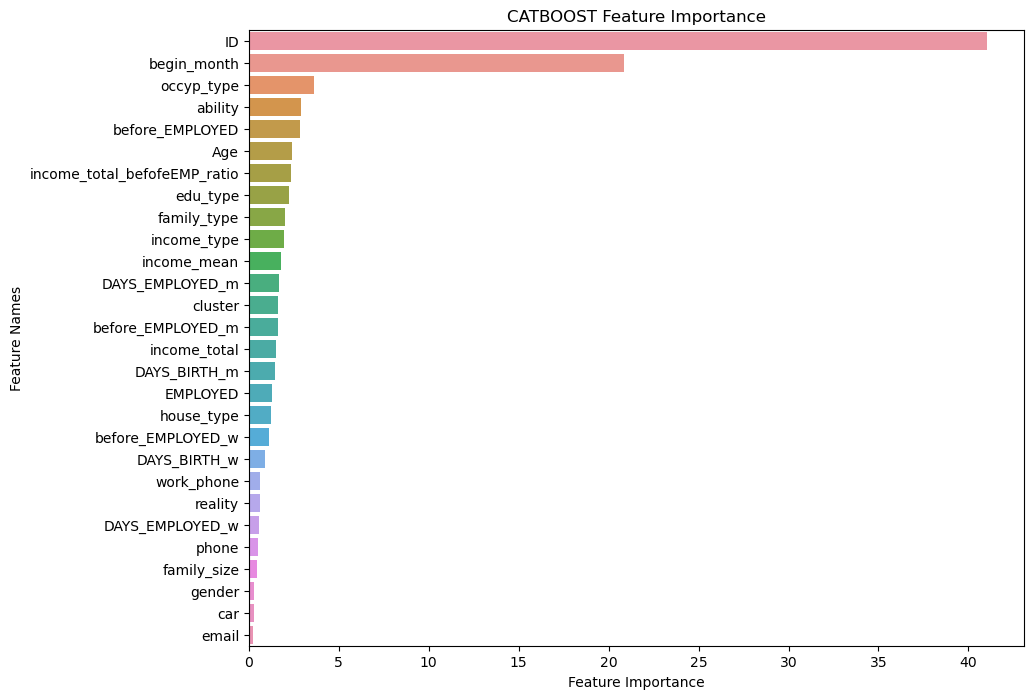

In [39]:
plot_feature_importance(model_cat.get_feature_importance(),X_test.columns,'CATBOOST')

## Submission

### submission 파일 불러오기

In [40]:
sub = pd.read_csv('sample_submission.csv')

### submission 파일 저장

In [41]:
sub.iloc[:, 1:] = cat_pred_test
sub

,index,0,1,2
0,26457,0.110518,0.175156,0.714325
1,26458,0.333052,0.215816,0.451132
2,26459,0.034342,0.073493,0.892165
3,26460,0.055731,0.079089,0.865180
4,26461,0.084515,0.235911,0.679573
...,...,...,...,...
9995,36452,0.072057,0.214618,0.713325
9996,36453,0.299971,0.186160,0.513869
9997,36454,0.050142,0.119352,0.830506
9998,36455,0.143825,0.309713,0.546462


In [42]:
sub.to_csv('answer/submission0523_Final_eidt1.csv', index=False)